In [30]:
import random

In [31]:
random_seed = 10
random.seed(random_seed)

In [32]:
%pip install swifter
%pip install python-dotenv
%pip install bertopic
%pip install tensorflow
%pip install sentence-transformers
%pip install gensim

In [34]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [35]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

In [36]:
#shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
df.head(5)

pk                                     source         internal_id  \
0   1  Roundtable on Sustainable Palm Oil (RSPO)  500Mg00000L0di6IAB   
1   2  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVwYqYAK   
2   3  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVxmPYAS   
3   4  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVGg2YAG   
4   5  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003vMwFgYAK   

                        status submitted_on accepted_on last_updated_on  \
0                       Closed    2/26/2025   4/15/2025       5/20/2025   
1  In Progress - Investigation   11/29/2024   1/16/2025       1/16/2025   
2  In Progress - Investigation   11/28/2024   1/21/2025       1/21/2025   
3  In Progress - Investigation   10/16/2024  11/18/2024      11/18/2024   
4  In Progress - Investigation    9/11/2024  10/29/2024      10/29/2024   

      country            region    complainants  \
0   Indonesia  Sumatera Selatan    Confidential   
1      Mexico               NaN    Confidential   
2    Colombia   Montes de María    Confidential   
3   Indonesia              Riau  S. Samsul Hadi   
4  Costa Rica      Pococi/Limón    Confidential   

                         respondents          respondent_sector  \
0             PT Sawit Mas Sejahtera           Oil Palm Growers   
1  INDUSTRIAS OLEOPALMA S.A. DE C.V.           Oil Palm Growers   
2                   OLEOFLORES S A S  Processors and/or Traders   
3              PT Guntung Idamannusa           Oil Palm Growers   
4           Compañía Palma Tica S.A.           Oil Palm Growers   

                           respondent_parent_company respondent_supplier  \
0                        Golden Agri-Resources (GAR)                 NaN   
1                  Oleoquímica Mexicana S.A. de C.V.                 NaN   
2                            Musim Mas Holdings Pte.                 NaN   
3  Compañía Industrial Aceitera Coto Cincuenta y ...                 NaN   
4                                                NaN                 NaN   

                                             summary  \
0  That the Respondent allegedly transferred the ...   
1  The Complainant alleges that the Respondent ha...   
2  1.The Complainant alleges that the Respondent ...   
3  The Respondent's Corporate Social Responsibili...   
4  The Complainant alleges that the Respondent br...   

                                             history  \
0  2025-05-20: CP's Decision Letter dated 20. 05....   
1  2025-04-30: The Secretariat furnished the Resp...   
2  2025-04-30: The Complaints Panels directive to...   
3  2025-04-30: The Complaints Panel has directed ...   
4  2025-04-30: The Briefing Note is in progress. ...   

                                       external_link  \
0  https://rspo.my.site.com/Complaint/s/case/500M...   
1  https://rspo.my.site.com/Complaint/s/case/500G...   
2  https://rspo.my.site.com/Complaint/s/case/500G...   
3  https://rspo.my.site.com/Complaint/s/case/500G...   
4  https://rspo.my.site.com/Complaint/s/case/500G...   

                                extras  
0   {'case_number': 'RSPO/2025/02/RR'}  
1  {'case_number': 'RSPO/2024/17/MAM'}  
2   {'case_number': 'RSPO/2024/18/HN'}  
3   {'case_number': 'RSPO/2024/14/RH'}  
4  {'case_number': 'RSPO/2024/13/MAM'}

## Preprocessing

In [37]:
#stop words, lower case, and remove punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# preprocessing function
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    # Use regular expression to replace all punctuation with a space
    text = re.sub(f'[{re.escape("".join(punctuation))}]', ' ', text)
    tokens = text.split()
    # Removed the strip() call as regex handles punctuation removal
    # tokens = [word.strip("".join(punctuation)) for word in tokens]
    tokens = [word for word in tokens if word and word not in stop_words]

    return tokens

# Add cleaned tokens to the df
df["tokens"] = df["summary"].apply(clean_text)

# Define the list of words to filter out
words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges'}

# filter out words that we think are not helpful
df['flt_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])


df['flt_tokens'] = df['flt_tokens'].apply(lambda x: ' '.join(x))

## Embedding

In [38]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
        #adding this to see the shape of the embedding
        logging.info(f"Embedding shape for input: {emb.shape}")
        return emb
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)

    if 'embedding' not in df.columns:
        df['embedding'] = None

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

In [39]:
# embeddings are computed and saved in df
embedding_example = df.loc[df['embedding'].notnull(), 'embedding'].iloc[0]

print(type(embedding_example))  # we want a numpy array here
print(embedding_example.shape)  # This will tell us the embedding dimensions :)

<class 'numpy.ndarray'>
(384,)


## Model Creation

In [40]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [41]:
%pip install scikit-fuzzy

In [42]:
from skfuzzy.cluster import cmeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

In [13]:
# # Define Clustering Models
# soft_kmeans_model = GaussianMixture(n_components=20, random_state=42)
class FuzzyCMeansModel:
    def __init__(self, n_clusters=6, m=2, error=0.005, maxiter=1000):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.labels_ = None
        self.centers = None
        self.u = None  # Membership matrix

    def fit(self, X):
        self.centers, self.u, _, _, _, _, _ = cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter
        )
        self.labels_ = np.argmax(self.u, axis=0)
        return self

    def predict(self, X):
        return self.labels_

In [43]:
## bertopic.py ##

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)
embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()

# Initialize BERTopic model with a random_state for reproducibility

cluster_model = FuzzyCMeansModel(n_clusters= 6)
bertopic_model = BERTopic(hdbscan_model=cluster_model)

# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

#fix for indexing, store the actual topic ids assigned by bert
df_embeddings["bertopic_topic"] = topics
df_embeddings["bertopic_prob"] = probs

# Get actual fuzzy topic probabilities from the Fuzzy C-Means model
membership_probs = cluster_model.u.T  # shape = (n_docs, n_topics)

# Turn it into a DataFrame
membership_df = pd.DataFrame(membership_probs, columns=[f"Topic_{i}" for i in range(cluster_model.n_clusters)])

# Join with df_embeddings
df_embeddings = df_embeddings.reset_index(drop=True)
df_embeddings = pd.concat([df_embeddings, membership_df], axis=1)

# Now you can access per-topic probabilities per document
df_embeddings.head()

df_embeddings["topic"] = membership_df.idxmax(axis=1).apply(lambda x: int(x.split("_")[1]))
df_embeddings["probs"] = membership_df.max(axis=1)


# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

BERTopic Topics and Top Words:
{0: [('land', 0.10206125821605684), ('communities', 0.034178849116150746), ('local', 0.02882316053660037), ('rights', 0.02576687670255976), ('allegations', 0.02524483623332218), ('plasma', 0.023859516451190957), ('informed', 0.023376791929466557), ('complaint', 0.02279066078864668), ('hcv', 0.022654767293121846), ('prior', 0.021817675756224918)], 1: [('earth', 0.0973939961415367), ('ha', 0.09666210551103482), ('mighty', 0.09652166285058154), ('rapid', 0.09234163428064396), ('concession', 0.08954792918277583), ('response', 0.08553802560052694), ('deforestation', 0.07716787235648975), ('indications', 0.06666950075445949), ('cleared', 0.06169172322982858), ('forest', 0.06025470277268443)], 2: [('ffb', 0.026639101506574375), ('river', 0.024009725008393008), ('national', 0.02176940511451782), ('sustainable', 0.021382112610600145), ('products', 0.021150045843380313), ('rspos', 0.019006322320533463), ('non', 0.01865949009815813), ('cpo', 0.018471086122297236), (

In [44]:
membership_df

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
0    0.007184  0.009291  0.002132  0.974304  0.003190  0.003899
1    0.002081  0.002741  0.000583  0.992621  0.000887  0.001087
2    0.244586  0.662368  0.010104  0.017390  0.021356  0.044196
3    0.814074  0.097740  0.006654  0.009550  0.015639  0.056343
4    0.464211  0.369323  0.014445  0.020469  0.030805  0.100746
..        ...       ...       ...       ...       ...       ...
382  0.209148  0.558858  0.019334  0.117559  0.035505  0.059595
383  0.660501  0.128801  0.017873  0.019772  0.046550  0.126502
384  0.059860  0.041475  0.442217  0.019168  0.347243  0.090036
385  0.081358  0.057195  0.374726  0.026234  0.334592  0.125895
386  0.086196  0.060829  0.358984  0.027744  0.333141  0.133105

[387 rows x 6 columns]

In [45]:
df_embeddings['probs']

0      0.974304
1      0.992621
2      0.662368
3      0.814074
4      0.464211
         ...   
382    0.558858
383    0.660501
384    0.442217
385    0.374726
386    0.358984
Name: probs, Length: 387, dtype: float64

In [46]:
print(bertopic_model.get_topic_info())

   Topic  Count                               Name  \
0      0     92    0_land_communities_local_rights   
1      1     73            1_earth_ha_mighty_rapid   
2      2     71   2_ffb_river_national_sustainable   
3      3     53    3_gar_deforestation_linked_jaya   
4      4     50  4_workers_labour_union_employment   
5      5     48          5_eof_forest_mill_illegal   

                                      Representation  \
0  [land, communities, local, rights, allegations...   
1  [earth, ha, mighty, rapid, concession, respons...   
2  [ffb, river, national, sustainable, products, ...   
3  [gar, deforestation, linked, jaya, chain, leus...   
4  [workers, labour, union, employment, casual, d...   
5  [eof, forest, mill, illegal, gar, plantation, ...   

                                 Representative_Docs  
0  [eias video water collaboration colombian la c...  
1  [mighty earth rapid response 17 indications de...  
2  [points raised npp published challenging time ...  
3  [migh

## Raw Output

In [47]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic 0 Representation: ['land', 'communities', 'local', 'rights', 'allegations', 'plasma', 'informed', 'complaint', 'hcv', 'prior']
Topic 1 Representation: ['earth', 'ha', 'mighty', 'rapid', 'concession', 'response', 'deforestation', 'indications', 'cleared', 'forest']
Topic 2 Representation: ['ffb', 'river', 'national', 'sustainable', 'products', 'rspos', 'non', 'cpo', 'forest', 'member']
Topic 3 Representation: ['gar', 'deforestation', 'linked', 'jaya', 'chain', 'leuser', 'supply', 'sawit', 'ran', 'mighty']
Topic 4 Representation: ['workers', 'labour', 'union', 'employment', 'casual', 'daily', 'rights', 'working', 'bpjs', 'termination']
Topic 5 Representation: ['eof', 'forest', 'mill', 'illegal', 'gar', 'plantation', 'plantations', 'area', 'grievance', 'riau']


In [48]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

# Visualizations

In [49]:
model_name = "LLM-BERTopic"

## Create Dataframe with Results

In [50]:
import re
import pandas as pd

def format_bertopic_sentences(model, embeddings, n_topics):
    rows = []

    for index, row in embeddings.iterrows():
        doc_num = index
        dominant_topic = row['topic']
        topic_prob = row['probs']
        text = row['flt_tokens']

        # Topic contribution breakdown
        topic_dist = {f"Topic_{i}_Perc": 0.0 for i in range(n_topics)}
        topic_binary = {f"Topic_{i}_Indicate": 0 for i in range(n_topics)}

        shared_perc = 0.0
        dom_topic_num = dominant_topic if dominant_topic != -1 else None
        dom_topic_prob = topic_prob
        is_outlier = (dominant_topic == -1)
        itr = 0

        # Simulate topic breakdown via probability — if available
        if not is_outlier and isinstance(topic_prob, float):
            # Use the membership probabilities from the row if available
            for i in range(n_topics):
                topic_dist[f"Topic_{i}_Perc"] = round(row[f'Topic_{i}'] * 100, 2)
                if row[f'Topic_{i}'] > 0: # Indicate if there's any contribution
                    topic_binary[f"Topic_{i}_Indicate"] = 1

            shared_perc = topic_dist[f"Topic_{dominant_topic}_Perc"]
            dom_topic_num = dominant_topic
            itr = sum(list(topic_binary.values())) # Count number of topics with contribution
        else:
            # Optionally apply fallback logic for topic proportion
            topic_dist[f"Topic_{dominant_topic}_Perc"] = 100.0
            topic_binary[f"Topic_{dominant_topic}_Indicate"] = 1
            dom_topic_num = dominant_topic
            itr = 1

        # Keywords
        if dom_topic_num is not None and dom_topic_num != -1:
            keywords = ", ".join([word for word, _ in model.get_topic(row['bertopic_topic'])])
        else:
            keywords = "Outlier Topic"

        # Construct the document row
        row_data = {
            'Document_Num': doc_num,
            'Dominant_Topic': dom_topic_num,
            'Topic_%_Contrib': dom_topic_prob,
            'Topic_Keywords': keywords,
            'Text': text,
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row_data.update(topic_dist)
        row_data.update(topic_binary)
        rows.append(row_data)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [51]:
df_embeddings

pk                                     source         internal_id  \
0      1  Roundtable on Sustainable Palm Oil (RSPO)  500Mg00000L0di6IAB   
1      2  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVwYqYAK   
2      3  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVxmPYAS   
3      4  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003xVGg2YAG   
4      5  Roundtable on Sustainable Palm Oil (RSPO)  500GB00003vMwFgYAK   
..   ...                                        ...                 ...   
382  422                       Wilmar International                 NaN   
383  423                       Wilmar International                 NaN   
384  426                       Wilmar International                 NaN   
385  429                       Wilmar International                 NaN   
386  430                       Wilmar International                 NaN   

                          status submitted_on accepted_on last_updated_on  \
0                         Closed    2/26/2025   4/15/2025       5/20/2025   
1    In Progress - Investigation   11/29/2024   1/16/2025       1/16/2025   
2    In Progress - Investigation   11/28/2024   1/21/2025       1/21/2025   
3    In Progress - Investigation   10/16/2024  11/18/2024      11/18/2024   
4    In Progress - Investigation    9/11/2024  10/29/2024      10/29/2024   
..                           ...          ...         ...             ...   
382                       Closed    2/25/2015         NaN             NaN   
383                       Closed    12/8/2015         NaN             NaN   
384                       Closed    8/19/2015         NaN             NaN   
385                       Closed     6/5/2015         NaN             NaN   
386                       Closed    6/11/2014         NaN             NaN   

        country            region                complainants  ...  \
0     Indonesia  Sumatera Selatan                Confidential  ...   
1        Mexico               NaN                Confidential  ...   
2      Colombia   Montes de María                Confidential  ...   
3     Indonesia              Riau              S. Samsul Hadi  ...   
4    Costa Rica      Pococi/Limón                Confidential  ...   
..          ...               ...                         ...  ...   
382         NaN               NaN  Friends of the Earth (FoE)  ...   
383         NaN               NaN  Friends of the Earth (FoE)  ...   
384         NaN               NaN        Greenomics Indonesia  ...   
385         NaN               NaN        Greenomics Indonesia  ...   
386         NaN               NaN        Greenomics Indonesia  ...   

    bertopic_topic bertopic_prob   Topic_0   Topic_1   Topic_2   Topic_3  \
0                4          None  0.007184  0.009291  0.002132  0.974304   
1                4          None  0.002081  0.002741  0.000583  0.992621   
2                0          None  0.244586  0.662368  0.010104  0.017390   
3                2          None  0.814074  0.097740  0.006654  0.009550   
4                2          None  0.464211  0.369323  0.014445  0.020469   
..             ...           ...       ...       ...       ...       ...   
382              0          None  0.209148  0.558858  0.019334  0.117559   
383              2          None  0.660501  0.128801  0.017873  0.019772   
384              1          None  0.059860  0.041475  0.442217  0.019168   
385              1          None  0.081358  0.057195  0.374726  0.026234   
386              1          None  0.086196  0.060829  0.358984  0.027744   

      Topic_4   Topic_5 topic     probs  
0    0.003190  0.003899     3  0.974304  
1    0.000887  0.001087     3  0.992621  
2    0.021356  0.044196     1  0.662368  
3    0.015639  0.056343     0  0.814074  
4    0.030805  0.100746     0  0.464211  
..        ...       ...   ...       ...  
382  0.035505  0.059595     1  0.558858  
383  0.046550  0.126502     0  0.660501  
384  0.347243  0.090036     2  0.442217  
385  0

In [52]:
# Assuming membership_df is available from the previous cell
# Get the number of topics from the membership_df columns (excluding original columns)
number_of_topics = len(membership_df.columns)


dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)

## Data Exploration

In [53]:
#sorting by % topic contribution for readability
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 0].sort_values(by='Topic_%_Contrib', ascending=False)

Document_Num  Dominant_Topic  Topic_%_Contrib  \
37             37               0         0.907538   
126           126               0         0.879600   
3               3               0         0.814074   
12             12               0         0.752096   
383           383               0         0.660501   
..            ...             ...              ...   
346           346               0         0.264976   
370           370               0         0.264288   
102           102               0         0.263299   
357           357               0         0.261537   
371           371               0         0.261112   

                                        Topic_Keywords  \
37   ffb, river, national, sustainable, products, r...   
126  ffb, river, national, sustainable, products, r...   
3    ffb, river, national, sustainable, products, r...   
12   ffb, river, national, sustainable, products, r...   
383  ffb, river, national, sustainable, products, r...   
..                                                 ...   
346  ffb, river, national, sustainable, products, r...   
370  ffb, river, national, sustainable, products, r...   
102  ffb, river, national, sustainable, products, r...   
357  ffb, river, national, sustainable, products, r...   
371  ffb, river, national, sustainable, products, r...   

                                                  Text  Is_Outlier  \
37   ownership control influence called non member ...       False   
126  1 fpic related issues criteria 2 3 6 4 7 6 bas...       False   
3    corporate social responsibility csr program co...       False   
12   failure carry corporate social responsibility ...       False   
383  rimba harapan saksti rhs sarana titian permata...       False   
..                                                 ...         ...   
346  non compliant products yp plantation holdings ...       False   
370  non compliant products alas kusuma enter wilma...       False   
102  western pacific oils claimed purchasing mb sho...       False   
357  non compliant products amanah saham pahang ber...       False   
371  non compliant products enter wilmar supply cha...       False   

     Dom_Topics_Num  Topic_0_Perc  Topic_1_Perc  Topic_2_Perc  Topic_3_Perc  \
37                6         90.75          6.36          0.24          0.36   
126               6         87.96          8.25          0.33          0.52   
3                 6         81.41          9.77          0.67          0.95   
12                6         75.21         16.92          0.70          1.28   
383               6         66.05         12.88          1.79          1.98   
..              ...           ...           ...           ...           ...   
346               6         26.50         20.27          7.70         12.26   
370               6         26.43         20.29          7.73         12.37   
102               6         26.33         20.30          7.81         12.55   
357               6         26.15         20.43          7.83         12.87   
371               6         26.11         20.19          7.85         12.59   

     Topic_4_Perc  Topic_5_Perc  Topic_0_Indicate  Topic_1_Indicate  \
37           0.55          1.73                 1                 1   
126          0.78          2.15                 1                 1   
3            1.56          5.63                 1                 1   
12           1.59          4.30                 1                 1   
383          4.66         12.65                 1                 1   
..            ...           ...               ...               ...   
346         13.75         19.51                 1                 1   
370         13.79         19.39                 1                 1   
102         13.92         19.10                 1                 1   
357         13.88         18.83                 1                 1   
371         13.85         19.41                 1                 1   

     Topic_2_Ind

In [54]:
#df_embeddings[df_embeddings['topic'] == 0]

In [78]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3].sort_values(by='Topic_%_Contrib', ascending=False)

Document_Num  Dominant_Topic  Topic_%_Contrib  \
9               9               3         0.995430   
22             22               3         0.993889   
62             62               3         0.993738   
1               1               3         0.992621   
36             36               3         0.990623   
92             92               3         0.988066   
66             66               3         0.986337   
24             24               3         0.981610   
297           297               3         0.981166   
23             23               3         0.975753   
43             43               3         0.974651   
0               0               3         0.974304   
18             18               3         0.974228   
120           120               3         0.974144   
21             21               3         0.973843   
41             41               3         0.972631   
205           205               3         0.970853   
79             79               3         0.970724   
71             71               3         0.970003   
64             64               3         0.968726   
45             45               3         0.967256   
17             17               3         0.966633   
90             90               3         0.958839   
65             65               3         0.958519   
58             58               3         0.957639   
72             72               3         0.956350   
98             98               3         0.951196   
48             48               3         0.950815   
33             33               3         0.950719   
54             54               3         0.947571   
5               5               3         0.946837   
96             96               3         0.946778   
39             39               3         0.945960   
60             60               3         0.933353   
67             67               3         0.928191   
78             78               3         0.925549   
235           235               3         0.895159   
207           207               3         0.663369   
367           367               3         0.567649   
359           359               3         0.559169   
351           351               3         0.559103   
366           366               3         0.542514   
353           353               3         0.524257   
376           376               3         0.463747   
362           362               3         0.459079   
289           289               3         0.458672   
206           206               3         0.437461   
288           288               3         0.427342   
290           290               3         0.415159   
348           348               3         0.410489   

                                        Topic_Keywords  \
9    workers, labour, union, employment, casual, da...   
22   workers, labour, union, employment, casual, da...   
62   workers, labour, union, employment, casual, da...   
1    workers, labour, union, employment, casual, da...   
36   workers, labour, union, employment, casual, da...   
92   workers, labour, union, employment, casual, da...   
66   workers, labour, union, employment, casual, da...   
24   workers, labour, union, employment, casual, da...   
297  workers, labour, union, employment, casual, da...   
23   workers, labour, union, employment, casual, da...   
43   workers, labour, union, employment, casual, da...   
0    workers, labour, union, employment, casual, da...   
18   workers, labour, union, employment, casual, da...   
120  workers, labour, union, employment, casual, da...   
21   workers, labour, union, employment, casual, da...   
41   workers, labour, union, employment, casual, da...   
205  workers, labour, union, employment, casual, da...   
79   workers, labour, union, employment, casual, da...   
71   workers, labour, union, employment, casual, da...   
64   workers, labour, union, employment, casual, da...   
45   workers, labour, union, emp

## Wordcloud

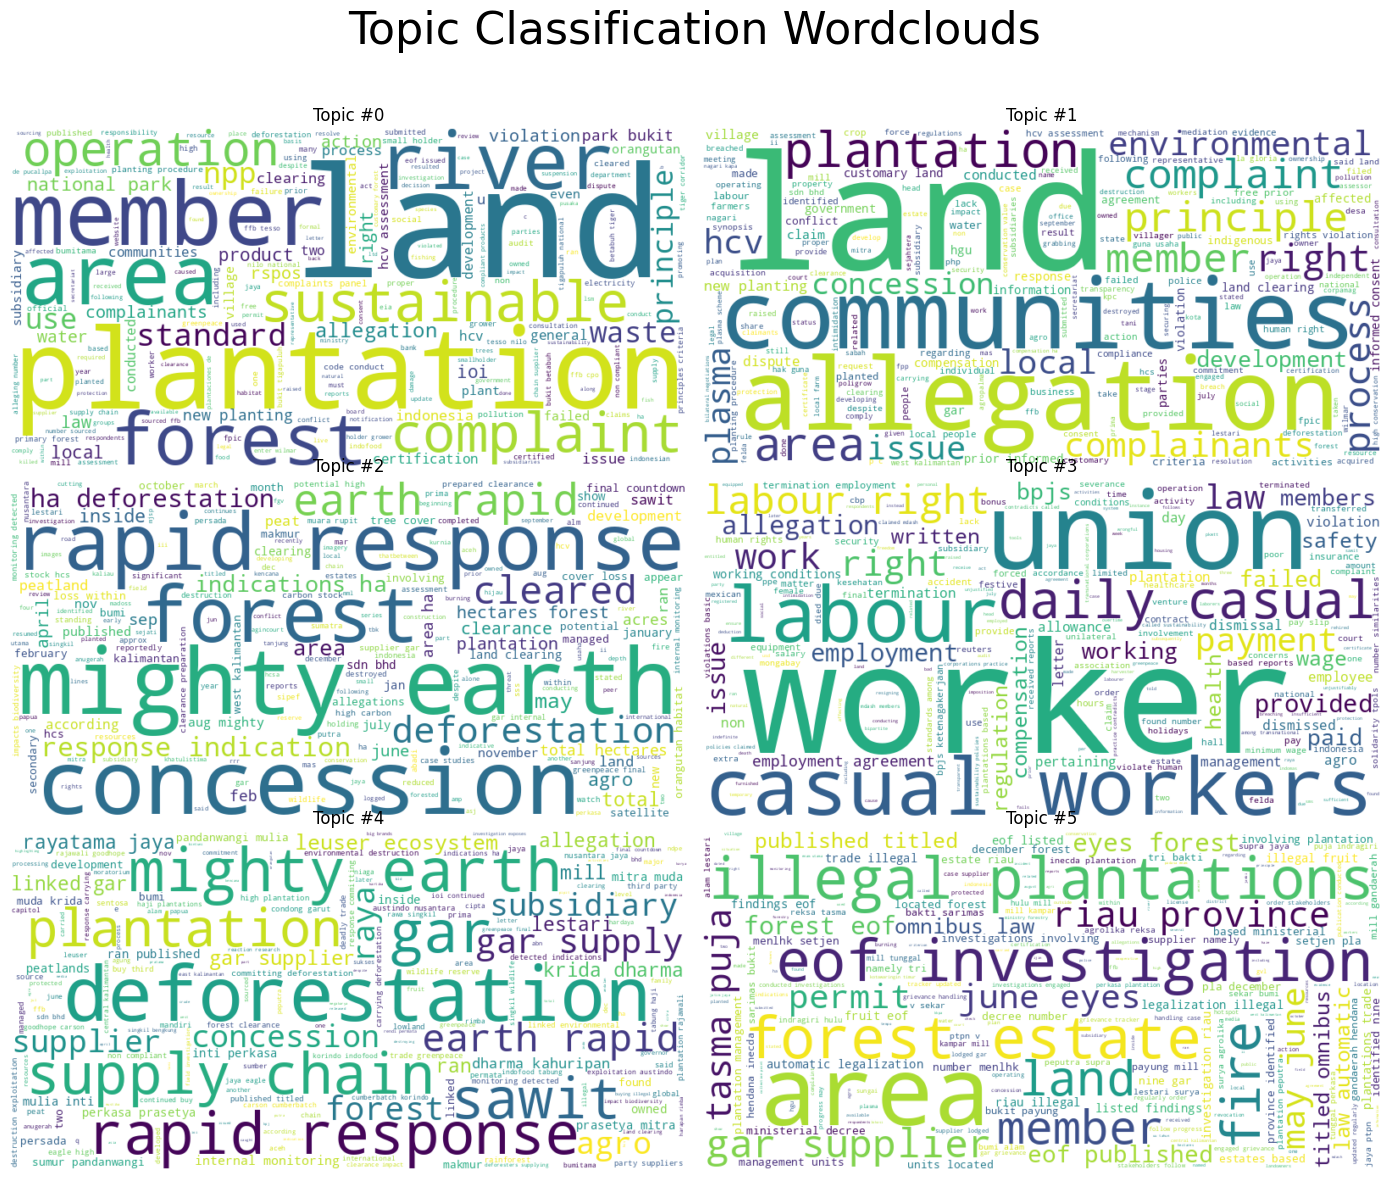

In [56]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds', n_topics=6)

## Dominant Topic Frequency

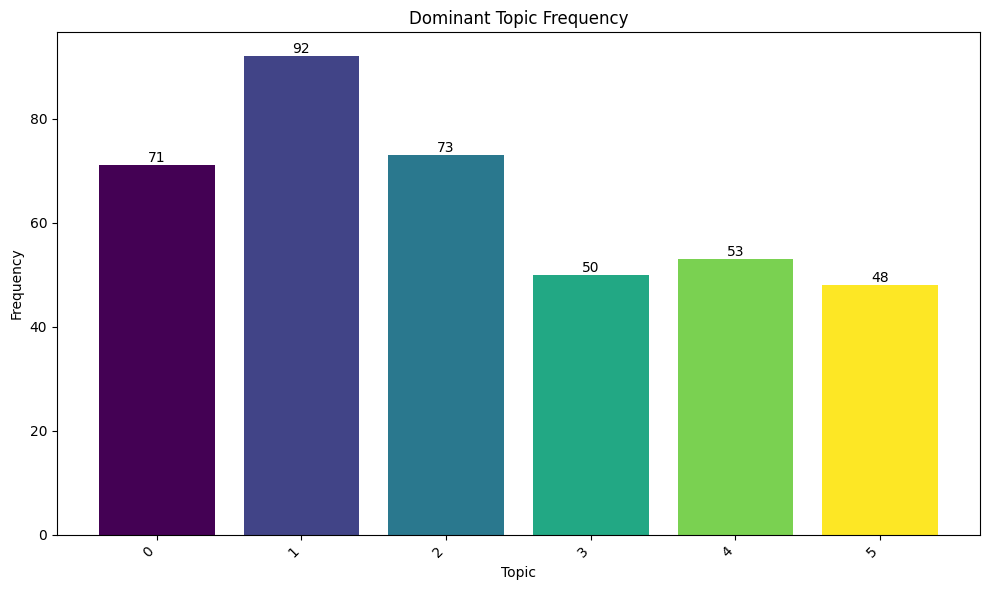

In [66]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

# Ensure dominant_topic_df is available
if  'dominant_topic_df' not in locals():
    print("Error:  dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    #https://colab.research.google.com/drive/1jQiYlqZ7jpm4bk9UP0JvYhVLkcXenWPF?authuser=1#scrollTo=Overall_Dominant_Topic_Share
    # Calculate topic share (frequency) from dominant_topic_df
    df_topic_share = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
    df_topic_share.columns = ['Topic', 'Frequency'] # Rename columns for clarity

    # Sort by frequency to potentially make the plot more informative
    #df_topic_share = df_topic_share.sort_values('Frequency', ascending=False)


    # Define colors (optional, adjust as needed based on number of topics)
    # Ensure the number of colors matches the number of topics to display
    num_topics_to_plot = len(df_topic_share)
    # You can use a colormap to generate enough colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics_to_plot))


    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

    # Plot the bars
    bars = ax.bar(df_topic_share['Topic'].astype(str), df_topic_share['Frequency'], color=colors)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    # Set plot title and labels
    plt.title('Dominant Topic Frequency')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
    plt.tight_layout() # Adjust layout
    plt.show()

## Topic Distribution per Doc

In [67]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['Document_Num'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

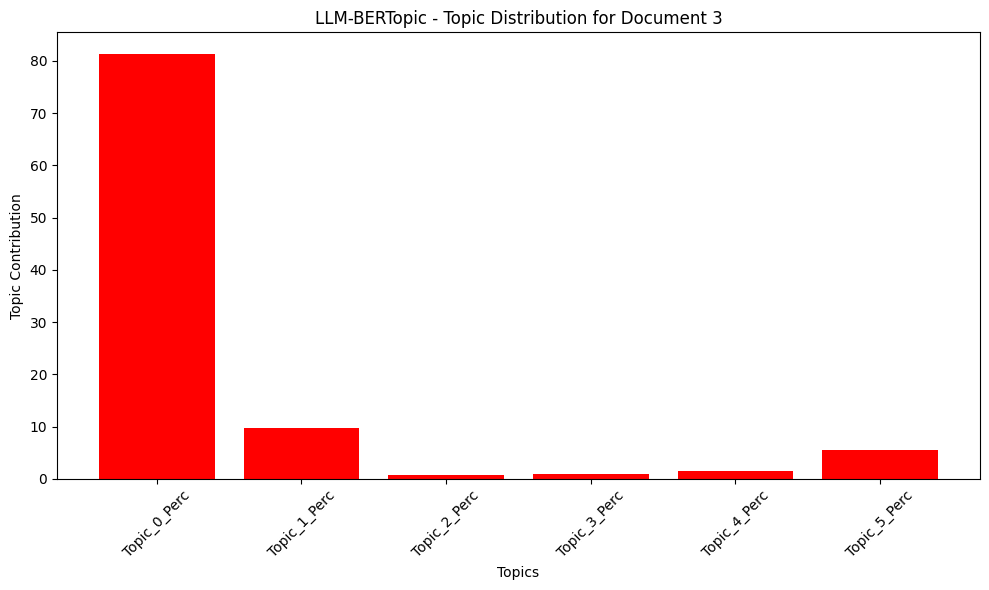

In [59]:
doc_number = 3    # Change This
topic_dist_doc(dominant_topic_df, number_of_topics, doc_num=doc_number)

## Overall Dominant Topic % Share

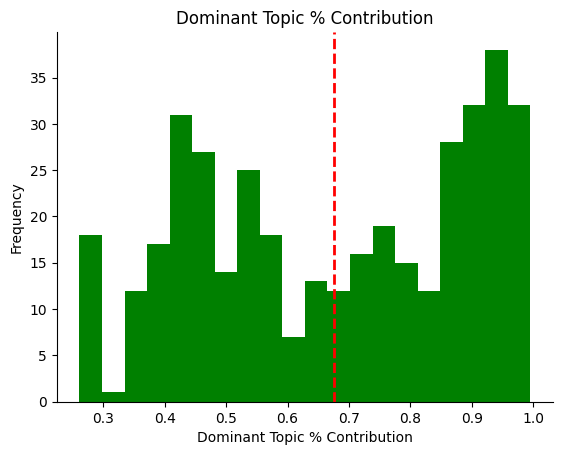

In [69]:
# Ensure dominant_topic_df is available
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Plot a histogram of the 'Topic_%_Contrib' column from dominant_topic_df
    dominant_topic_df['Topic_%_Contrib'].plot(kind='hist', bins=20, title='Dominant Topic % Contribution', color="green")
    plt.gca().spines[['top', 'right',]].set_visible(False)

    # Add Mean line
    mean_value = dominant_topic_df['Topic_%_Contrib'].mean()
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

    plt.xlabel('Dominant Topic % Contribution')
    plt.ylabel('Frequency')
    plt.show() # Add plt.show() to display the plot

# Scoring Methods

## Topic Coherence Score

In [70]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df_embeddings['flt_tokens']]
dictionary = Dictionary(texts)

topic_words = [[word for word, _ in bertopic_model.get_topic(i)] for i in range(len(bertopic_model.get_topics())) if i != -1]

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Topic Coherence:", coherence_score)


Topic Coherence: 0.5682004931725327


## Topic Diversity

In [71]:
topic_words = [bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics())) if i != -1]
top_words = [word for topic in topic_words for word, _ in topic[:10]]
unique_words = len(set(top_words))
total_words = len(top_words)
diversity = unique_words / total_words
print("Topic Diversity:", diversity)

Topic Diversity: 0.9


## Silhouette Score

In [72]:
from sklearn.metrics import silhouette_score

# Use embeddings and predicted topics (excluding -1)
mask = df_embeddings['topic'] != -1
score = silhouette_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Silhouette Score:", score)

Silhouette Score: 0.039351366


## Davies-Bouldin Index

In [73]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Davies-Bouldin Index:", score)

Davies-Bouldin Index: 4.157149652478705


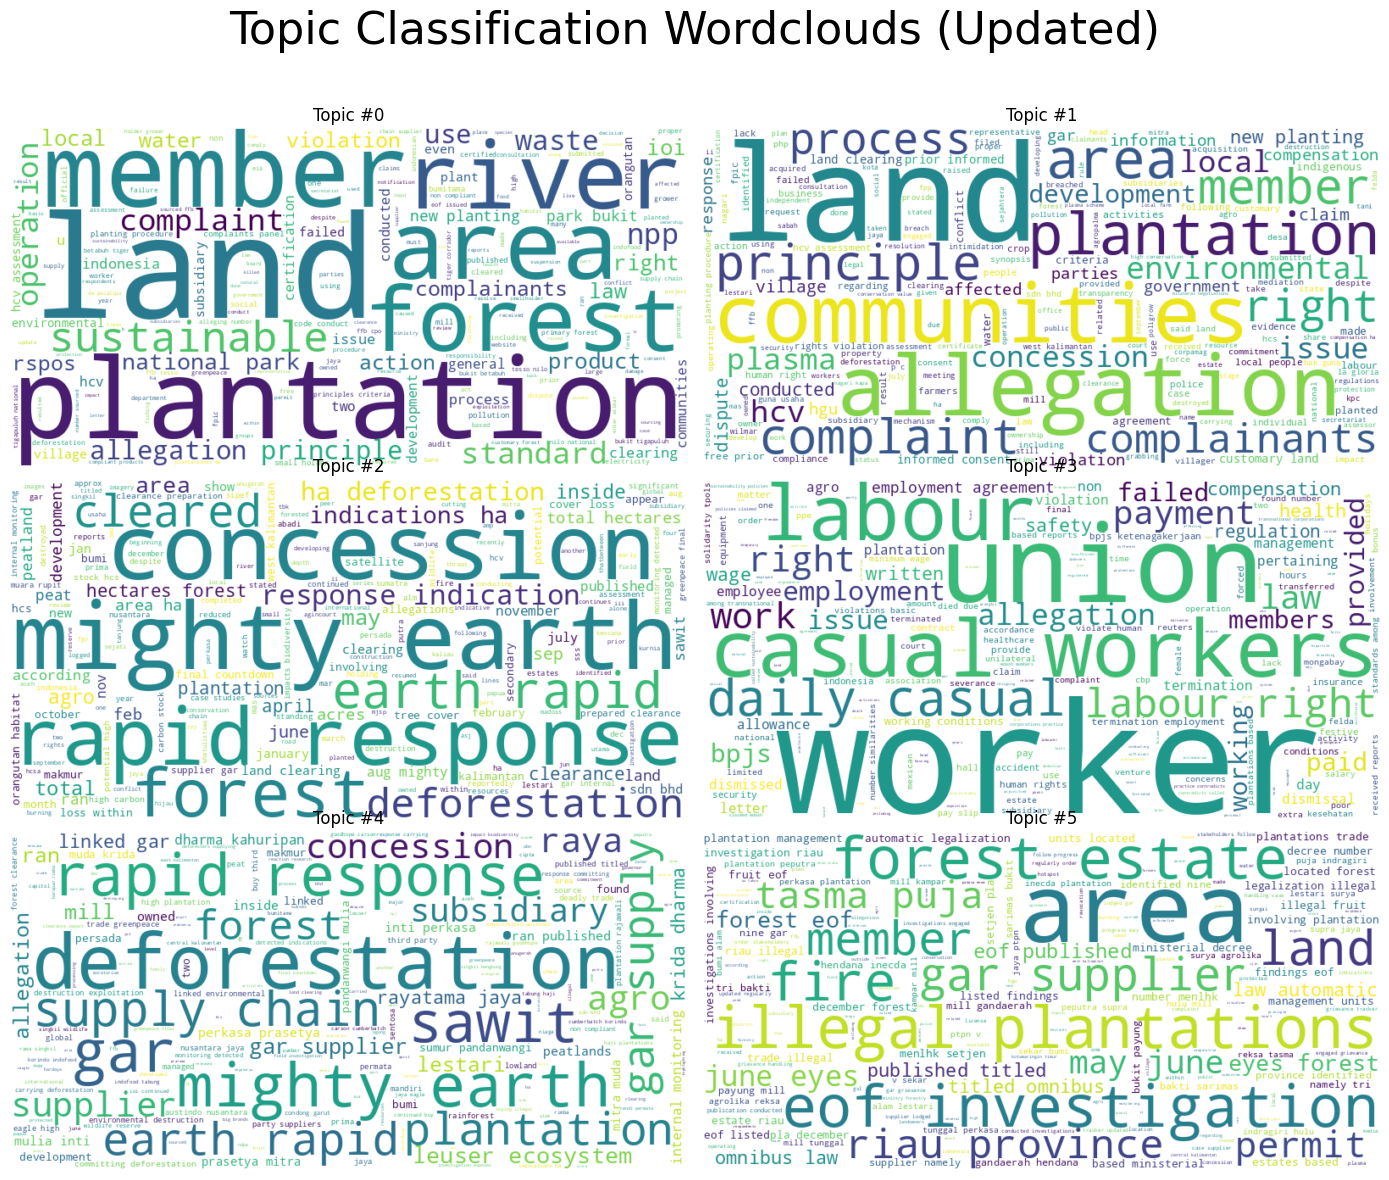

In [65]:
dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)
display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds (Updated)', n_topics=number_of_topics)

In [ ]:
bertopic_model.visualize_hierarchy()

In [ ]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)
